# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: Navegacion Autonoma**
#### Tecnológico de Monterrey
#### Dr. David Antonio Torres
#### **Equipo 4:**
#### Alejandro Bautista Ramos (A00973450)
#### Brandon Alexis Del Ángel Gómez (A01795429)
#### Mario Ramón Silva Rodríguez (A01795366)
#### Sergio Casto Reynoso (A01794980)
     

### **Proyecto Final**


# **Instrucciones**



1.   Genera el dataset de imágenes grabando la conducción del vehículo en Webots. En caso de que la ruta elegida nada más incluya vueltas hacia un solo lado, es necesario balancear el dataset de la siguiente manera: cinco vueltas en una dirección y cinco vueltas en el sentido contrario.
2.   Como parte de la generación de imágenes para el entrenamiento, es recomendable que se incluya situaciones en las cuales el vehículo sale de la pista y se regresa a ella. Esto le permitirá al vehículo mantenerse dentro de la pista cuando este maneje de manera autónoma. Asegúrate de generar, usando Python, un archivo con el ángulo de dirección para cada una de las imágenes contenidas en el dataset.
3.   Sube tu dataset a tu cuenta personal de Github siguiendo las instrucciones
4.   Crea un Notebook en Google Colab y accede al dataset que se subió a Github con el siguiente comando en la primera celda de código: !git clone https://... donde la liga debe coincidir con la carpeta en tu Github  que contiene las imágenes generadas por el simulador y el archivo con los ángulos de dirección mencionados en el punto 3.
5.   Para la importación del dataset en el Notebook y la implementación de Behavioral Cloning con redes neuronales profundas, sigue las instrucciones indicadas en el capítulo del libro y en el artículo listados a continuación.
Capítulo 10. Ranjan, S. y Senthamilarasu S.(2020). Applied Deep Learning and Computer Vision for Self-Driving Cars. Packt Publishing Ltd. Links to an external site.https://learning.oreilly.com/library/view/applied-deep-learning/9781838646301/?sso_link=yes&sso_link_from=ITESLinks to an external site.M
Bojarski, M. et. al. (2016). End to End Learning for Self Driving Cars. Disponible en: https://arxiv.org/abs/1604.07316Links to an external site.
6.   La red neuronal recomendada para el entrenamiento es denominada Nvidia Model. Sigue las instrucciones en el capítulo indicado en el libro de texto y en el artículo para preprocesar las imágenes y mantén en mente que estas deberán tener dimensiones de 66 por 200 pixeles para ajustarse a la capa de entrada de la red neuronal. En caso de usar una red distinta, haz los ajustes de imagen necesarios.
7. Las técnicas de Augmentation Technique y balanceo de datos es altamente recomendable para el entrenamiento.
8. Una vez concluido el entrenamiento, exporta tu modelo, haz uso del script en Python indicado en el capítulo del libro indicado y verifica tus resultados en el simulador Webots. Para verificar el entrenamiento, el mundo en Webots deberá incluir los sensores, tráfico y número de peatones indicados por el profesor en la active class correspondiente. Si es necesario, ponte en contacto con el profesor para conocer los detalles.
9. Para fines de evidencia de los resultados logrados, asegúrate de que el vehículo autónomo complete al menos una vuelta en la ruta definida durante el entrenamiento. El ajuste de la velocidad de conducción es arbitrario. Usando Webots, crea un video demostrativo de la conducción autónoma del vehículo incluyendo las condiciones del mundo indicadas en el paso anterior.
10. Crea un video, con una duración menor a dos minutos, en donde expliques los parámetros de la red neuronal y del entrenamiento que permitieron llegar a una solución correcta. Asegúrate de incluir en el video la evidencia de que el vehículo autónomo completó al menos una vuelta en el simulador. Puedes acelerar esta parte del video para lograr que esta evidencia quepa y cumpla con el requerimiento de duración del video. Sube tu video a tu canal de YouTube y guarda el enlace.
11. A manera de reporte, crea un documento que incluya tu script con los comentarios y el enlace de tu video en YouTube. Tanto el código como los comentarios son importantes para el documento.



# **Actividad**

In [1]:
# se clona el repositorio donde se encuentra el dataset de imágenes y el archivo csv con los ángulos de giro del volante
!git clone https://github.com/a-bautista/autonomous-vehicle.git

Cloning into 'autonomous-vehicle'...
remote: Enumerating objects: 5023, done.
remote: Counting objects: 100% (850/850), done.
remote: Compressing objects: 100% (849/849), done.
remote: Total 5023 (delta 1), reused 850 (delta 1), pack-reused 4173
Receiving objects: 100% (5023/5023), 62.19 MiB | 16.01 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (4171/4171), done.


In [1]:
# se importan librerías
import os, sys
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Lambda, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from random import shuffle

# Supresión de warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [4]:
# se revisa que la versión de tensorflow sea 2.15 para que pueda ejecutarse con la instalación de Python en Webots
import tensorflow as tf
print(tf.__version__)

2.15.0


In [8]:
# versión de Python soportada para tensorflow 2.15
print(sys.version)

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


In [3]:
# Definir las rutas de las imágenes y el archivo CSV
image_folder_path = '/content/autonomous-vehicle/images'
csv_file_path = '/content/autonomous-vehicle/driving_angles.csv'

# Cargar el archivo CSV
data = pd.read_csv(csv_file_path)

# Mostrar las primeras filas del archivo CSV para verificar la carga
print(data.head())

        filename  angle  speed  left  right
0    image_0.png    0.0    5.0     0      0
1   image_25.png    0.0    5.0     0      0
2   image_50.png    0.0    5.0     0      0
3   image_75.png    0.0    5.0     0      0
4  image_100.png    0.0    5.0     0      0


In [4]:
# se borra la primera imagen porque está en negro (cuando se inicializa la cámara)
data = data[data['filename'] != 'image_0.png']

# Función para cargar y preprocesar las imágenes
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(66, 200))
    img_array = image.img_to_array(img)
    return img_array / 255.0

# Cargar y preprocesar todas las imágenes
images = []
angles = []

for index, row in data.iterrows():
    image_path = os.path.join(image_folder_path, row['filename'])  # Usar la columna 'filename'
    img_array = preprocess_image(image_path)
    if img_array is not None:
        images.append(img_array)
        angles.append(row['angle'])

# Convertir listas a arrays de numpy
X = np.array(images)
y = np.array(angles)

Total data antes de la limpieza: 4168
Hist: [   5   23   15    3   29   65   89  180  507  289  633 1190  585  286
   86   28   15   42   15   18    5   10   15    2   33]


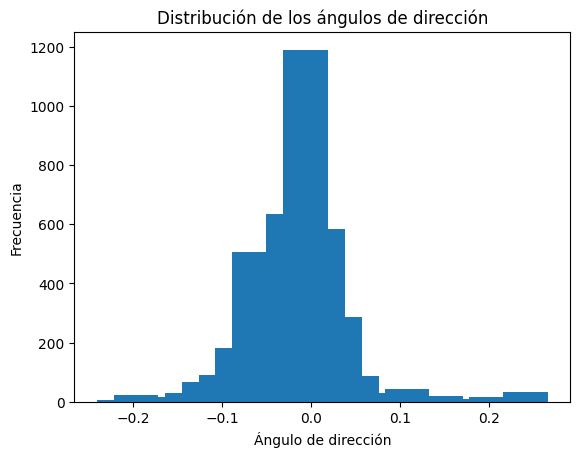

Removed: 3206
Total data después de la limpieza: 962


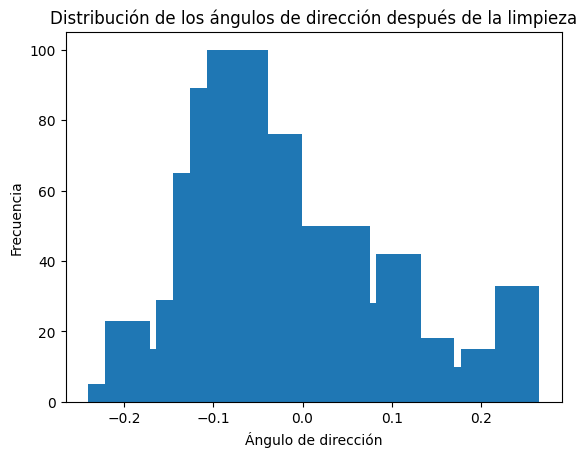

In [5]:
# Definir el número de bins para la distribución
num_bins = 25
samples_per_bin = 100  # Número reducido para los ángulos cercanos a cero

# Imprimir el número de datos antes de la limpieza
print(f'Total data antes de la limpieza: {len(data)}')

# Calcula el histograma de los ángulos de dirección
hist, bins = np.histogram(y, num_bins)

# Imprime la distribución actual
print('Hist:', hist)

# Muestra el histograma
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.title('Distribución de los ángulos de dirección')
plt.xlabel('Ángulo de dirección')
plt.ylabel('Frecuencia')
plt.show()

# Lista para almacenar los índices de las muestras a eliminar
remove_list = []

# Itera sobre cada contenedor del histograma
for j in range(num_bins):
    list_ = []
    # Agrega los índices de las muestras en el contenedor actual
    for i in range(len(y)):
        if y[i] > bins[j] and y[i] <= bins[j+1]:
            list_.append(i)
    # Baraja los índices y conserva solo los necesarios
    shuffle(list_)

    # Ajusta samples_per_bin según la posición del bin
    if bins[j] >= -0.05 and bins[j] <= 0.05:
        samples_to_keep = samples_per_bin // 2
    else:
        samples_to_keep = samples_per_bin

    remove_list.extend(list_[samples_to_keep:])

# Imprime el número de muestras a eliminar
print('Removed:', len(remove_list))

# Elimina las muestras del DataFrame
data.drop(data.index[remove_list], inplace=True)

# Imprimir el número de datos después de la limpieza
print(f'Total data después de la limpieza: {len(data)}')

# Calcula el histograma actualizado
hist, _ = np.histogram(data['angle'], num_bins)
plt.bar(center, hist, width=0.05)
plt.title('Distribución de los ángulos de dirección después de la limpieza')
plt.xlabel('Ángulo de dirección')
plt.ylabel('Frecuencia')
plt.show()

Training set: (769, 66, 200, 3), (769,)
Test set: (193, 66, 200, 3), (193,)


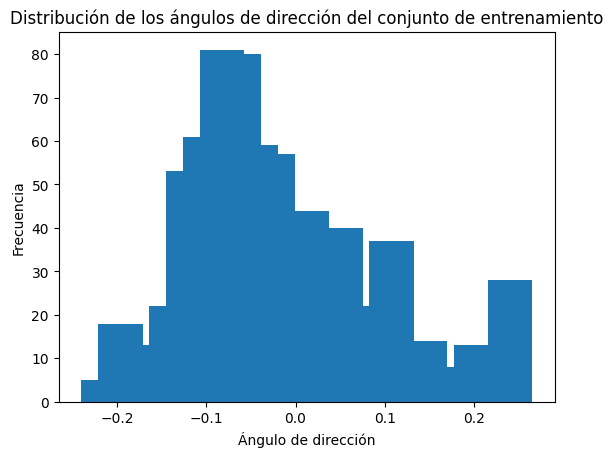

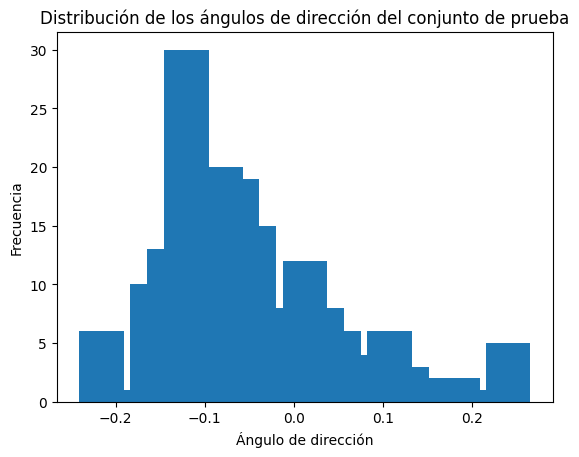

In [6]:
# Convertir listas a arrays de numpy nuevamente después de la limpieza
X = np.array([X[i] for i in range(len(X)) if i not in remove_list])
y = np.array([y[i] for i in range(len(y)) if i not in remove_list])

# Dividir el dataset en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificar las formas de los conjuntos de datos
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

# Calcula el histograma actualizado para el conjunto de entrenamiento
hist_train, _ = np.histogram(y_train, num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist_train, width=0.05)
plt.title('Distribución de los ángulos de dirección del conjunto de entrenamiento')
plt.xlabel('Ángulo de dirección')
plt.ylabel('Frecuencia')
plt.show()

# Calcula el histograma actualizado para el conjunto de prueba
hist_test, _ = np.histogram(y_test, num_bins)
plt.bar(center, hist_test, width=0.05)
plt.title('Distribución de los ángulos de dirección del conjunto de prueba')
plt.xlabel('Ángulo de dirección')
plt.ylabel('Frecuencia')
plt.show()

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def nvidia_model():
    # Modelo de red neuronal basado en la arquitectura de Nvidia para conducción autónoma
    model = tf.keras.Sequential()

    # Inicializa el modelo secuencial
    model.add(tf.keras.layers.Conv2D(filters=24, kernel_size=(5, 5), strides=2, input_shape=(66, 200, 3), activation='elu'))
    model.add(tf.keras.layers.Conv2D(filters=36, kernel_size=(5, 5), strides=2, activation='elu'))
    model.add(tf.keras.layers.Conv2D(filters=48, kernel_size=(5, 5), strides=2, activation='elu'))
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='elu'))
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='elu'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(100, activation='elu'))
    model.add(tf.keras.layers.Dense(50, activation='elu'))
    model.add(tf.keras.layers.Dense(10, activation='elu'))
    model.add(tf.keras.layers.Dense(1))

    optimizer = Adam(learning_rate=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
    return model

In [8]:
model = nvidia_model()
# Crea el modelo utilizando la función nvidia_model(), que devuelve el modelo basado en la arquitectura de Nvidia

print(model.summary())
# Imprime un resumen del modelo, que muestra la estructura y los parámetros de cada capa del modelo

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 100)               1

Epoch 1/10
13/13 [==============================] - 13s 81ms/step - loss: 0.5783 - val_loss: 0.0319
Epoch 2/10
13/13 [==============================] - 0s 22ms/step - loss: 0.0186 - val_loss: 0.0094
Epoch 3/10
13/13 [==============================] - 0s 23ms/step - loss: 0.0106 - val_loss: 0.0090
Epoch 4/10
13/13 [==============================] - 0s 22ms/step - loss: 0.0102 - val_loss: 0.0099
Epoch 5/10
13/13 [==============================] - 0s 22ms/step - loss: 0.0108 - val_loss: 0.0087
Epoch 6/10
13/13 [==============================] - 0s 20ms/step - loss: 0.0095 - val_loss: 0.0086
Epoch 7/10
13/13 [==============================] - 0s 22ms/step - loss: 0.0098 - val_loss: 0.0079
Epoch 8/10
13/13 [==============================] - 0s 23ms/step - loss: 0.0089 - val_loss: 0.0071
Epoch 9/10
13/13 [==============================] - 0s 20ms/step - loss: 0.0085 - val_loss: 0.0247
Epoch 10/10
13/13 [==============================] - 0s 22ms/step - loss: 0.0153 - val_loss: 0.0139


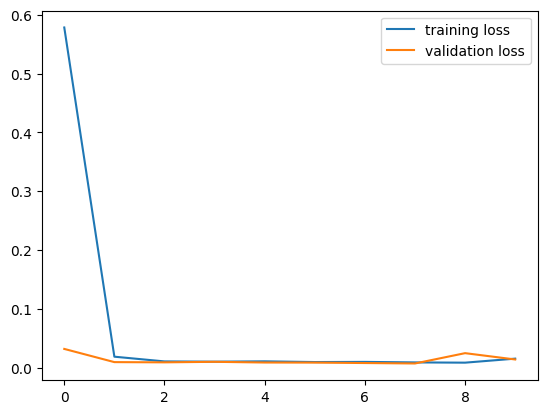

In [9]:
# Entrenar el modelo con el dataset
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64, verbose=1)

# Guardar el modelo entrenado
model.save('model.h5')

# Graficar la precisión del entrenamiento y validación
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()


7/7 [==============================] - 0s 5ms/step
Predicted angle: 0.04314001649618149, Actual angle: -0.11
Predicted angle: 0.062159501016139984, Actual angle: -0.02
Predicted angle: 0.0509994700551033, Actual angle: -0.045
Predicted angle: 0.06751605123281479, Actual angle: -0.095
Predicted angle: 0.05879766494035721, Actual angle: -0.065
Predicted angle: 0.04727468639612198, Actual angle: -0.05
Predicted angle: 0.040942586958408356, Actual angle: -0.195
Predicted angle: 0.06674126535654068, Actual angle: -0.095
Predicted angle: 0.05632830411195755, Actual angle: 0.125
Predicted angle: 0.06259945780038834, Actual angle: 0.035


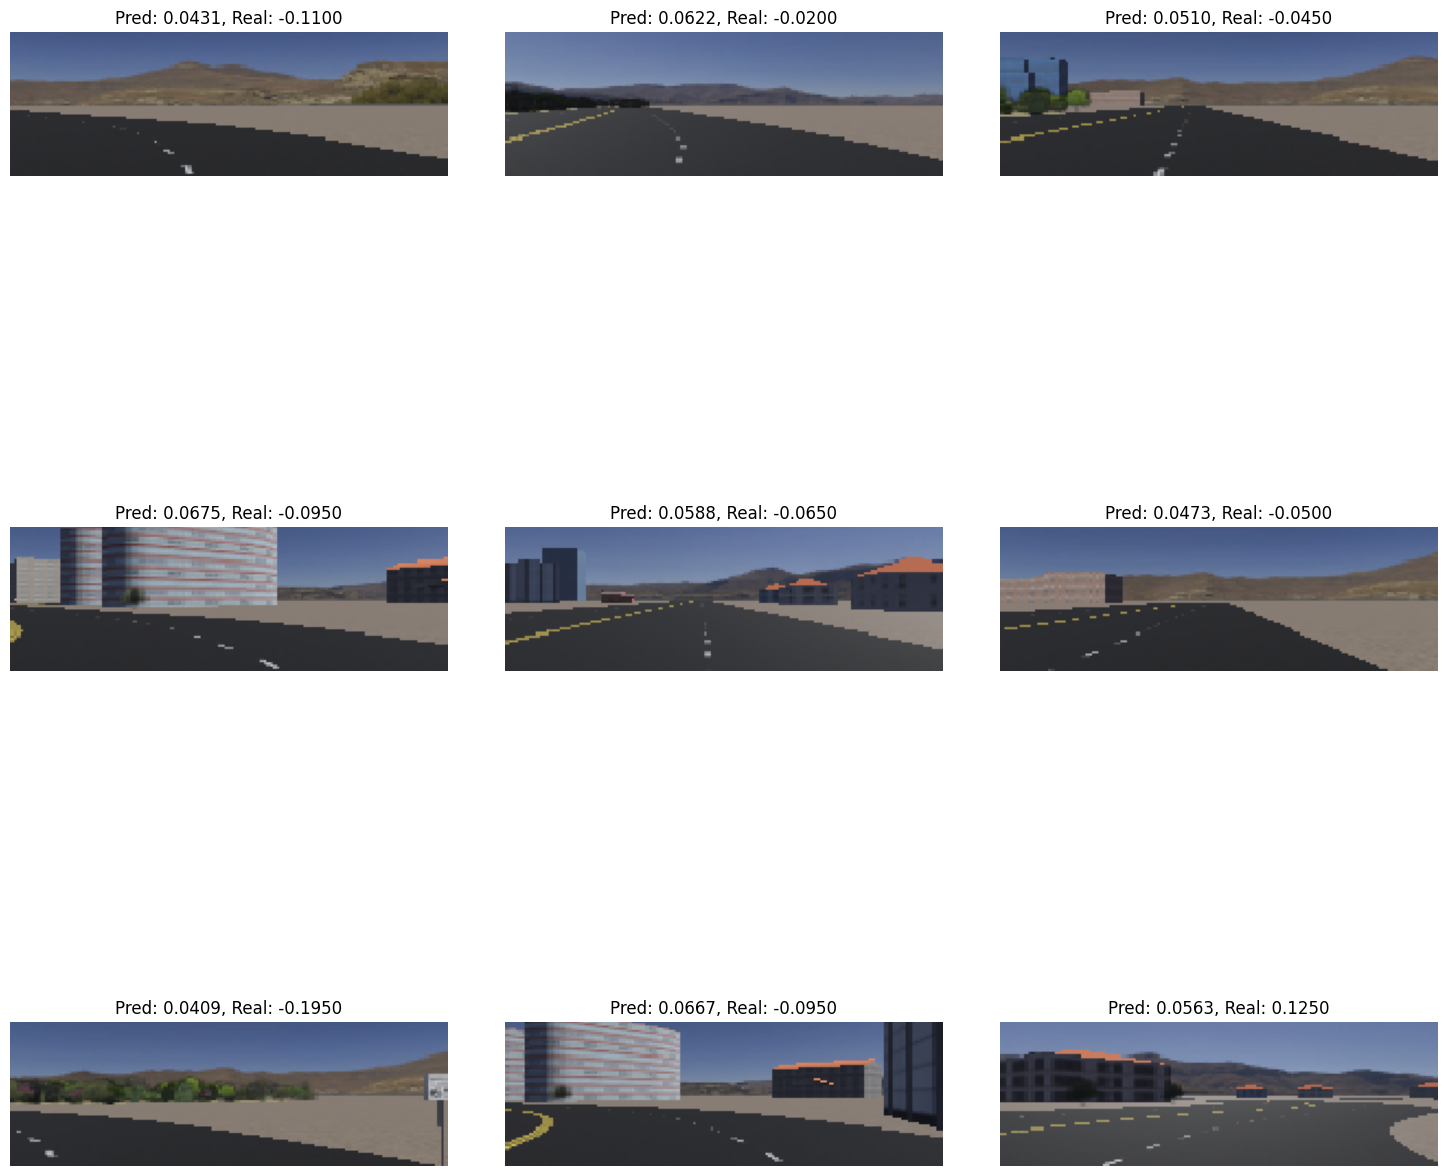

In [10]:
# Verificar las predicciones del modelo con las imágenes de prueba
y_pred = model.predict(X_test)

# Mostrar las primeras predicciones junto con los valores reales
for i in range(10):
    print(f"Predicted angle: {y_pred[i][0]}, Actual angle: {y_test[i]}")

# Visualizar algunas de las imágenes de prueba junto con las predicciones
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.tight_layout()

for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[i])
    ax.set_title(f"Pred: {y_pred[i][0]:.4f}, Real: {y_test[i]:.4f}")
    ax.axis('off')

plt.show()

In [11]:
# se guarda el modelo
model.save('model.h5')